# Download requirements

In [ ]:
install.packages('fpp2')

In [1]:
library(fpp2)

Warning message:
"package 'fpp2' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
-- Attaching packages ---------------------------------------------- fpp2 2.4 --
v ggplot2   3.1.1     v fma       2.4  
v forecast  8.14      v expsmooth 2.3  
Warning message:
"package 'forecast' was built under R version 3.6.3"Warning message:
"package 'fma' was built under R version 3.6.3"Warning message:
"package 'expsmooth' was built under R version 3.6.3"


# Load dataset

In [2]:
data <- read.csv('Data.csv')

In [3]:
summary(data)

      Date            Mkt.RF              SMB                HML         
 Min.   :196307   Min.   :-23.2400   Min.   :-15.3900   Min.   :-13.920  
 1st Qu.:197803   1st Qu.: -1.9600   1st Qu.: -1.5400   1st Qu.: -1.395  
 Median :199212   Median :  0.9250   Median :  0.1050   Median :  0.230  
 Mean   :199248   Mean   :  0.5648   Mean   :  0.2214   Mean   :  0.300  
 3rd Qu.:200708   3rd Qu.:  3.4000   3rd Qu.:  2.0650   3rd Qu.:  1.700  
 Max.   :202204   Max.   : 16.1000   Max.   : 18.3800   Max.   : 12.740  
      RMW                CMA                RF             NoDur        
 Min.   :-18.7600   Min.   :-6.7800   Min.   :0.0000   Min.   :-21.020  
 1st Qu.: -0.8175   1st Qu.:-1.0000   1st Qu.:0.1400   1st Qu.: -1.242  
 Median :  0.2400   Median : 0.1100   Median :0.3800   Median :  1.080  
 Mean   :  0.2752   Mean   : 0.2947   Mean   :0.3641   Mean   :  1.049  
 3rd Qu.:  1.2775   3rd Qu.: 1.4900   3rd Qu.:0.5100   3rd Qu.:  3.720  
 Max.   : 13.3800   Max.   : 9.0600   Max.  

# Predict cho Hlth portfolio

#### Lấy dữ liệu của Hlth porfolio

In [4]:
series <- ts(data = data$Hlth, start = c(1963,7), end = c(2022,4), frequency = 12)

In [5]:
series %>% summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-20.450  -1.808   1.125   1.069   3.947  29.520 

#### Khảo sát tập train từ 7/1963 - 12/1989

In [6]:
log_scale <- function(x) {log(1+x/100)} #scaler
log_inv <- function(x) {(exp(x)-1)*100} #inverter

In [7]:
series_train <- series %>% window(end=c(1989,12)) %>% log_scale

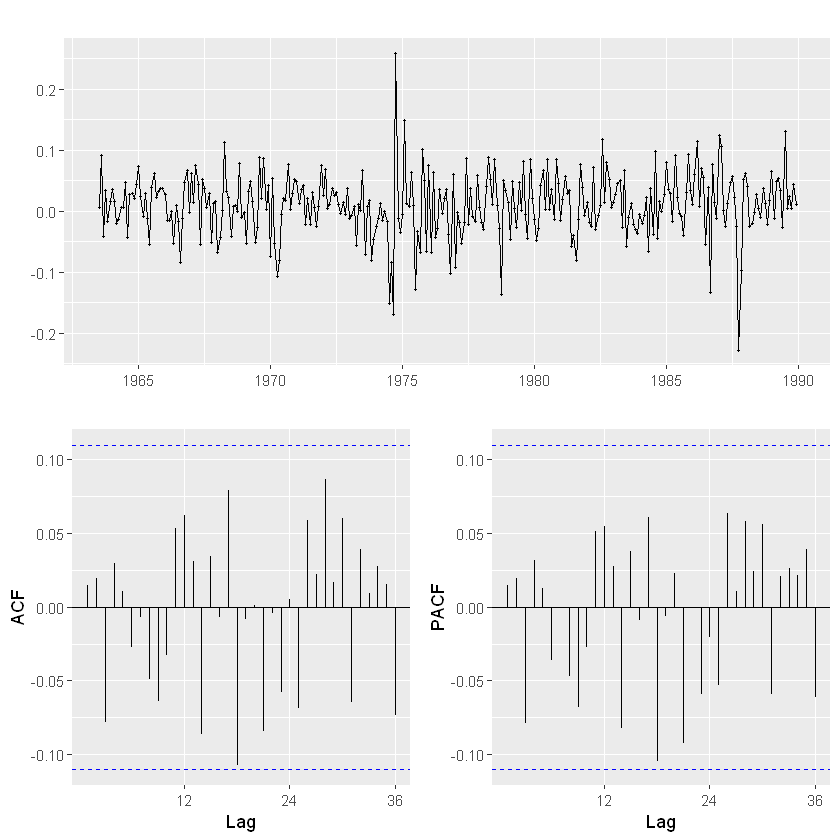

In [8]:
series_train %>% ggtsdisplay()

Biểu đồ dao động không có trend và seasonality quan sát được, nên không cần lấy difference và seasonal difference. <br>
Thử lại với hàm dò tìm bậc d: ndiffs cho order và nsdiffs cho seasonal.

In [9]:
series_train %>% ndiffs()

[1] 0

In [10]:
series_train %>% nsdiffs()

[1] 0

Kết quả d = 0 cho cả order và seasonal.

#### Phân tích p và q cho mô hình ARIMA

Thử dò tìm (p,d,q) với chế độ auto theo thuật toán Hyndman-Khandakar.

In [11]:
fit <- auto.arima(series_train, stepwise = FALSE, approximation = FALSE)
fit

Series: series_train 
ARIMA(0,0,0) with non-zero mean 

Coefficients:
        mean
      0.0099
s.e.  0.0029

sigma^2 estimated as 0.002709:  log likelihood=489.15
AIC=-974.3   AICc=-974.26   BIC=-966.78


	Ljung-Box test

data:  Residuals from ARIMA(0,0,0) with non-zero mean
Q* = 20.351, df = 23, p-value = 0.6207

Model df: 1.   Total lags used: 24



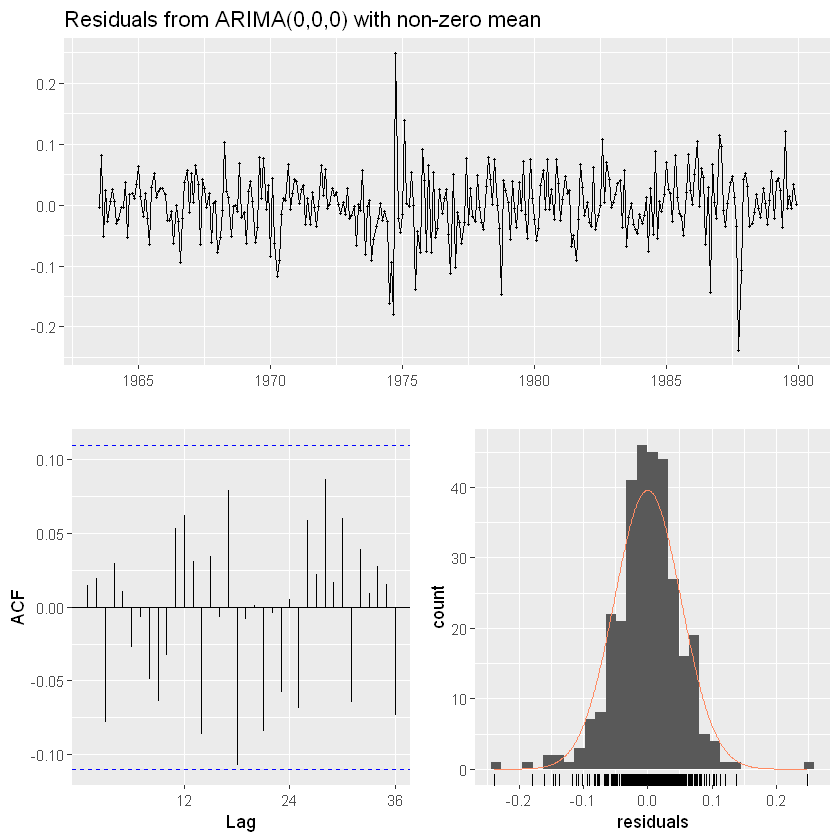

In [12]:
fit %>% checkresiduals()

Auto đề xuất ARIMA(0,0,0), Ljung-Box test cho p-value > 0.05 nên mô hình phù hợp.

Thử tất cả các mô hình đề xuất và so sánh theo tiêu chuẩn thông tin AIC, AICc, BIC, RMSE.

In [20]:
model <- list(ARIMA000 = c(0,0,0), ARIMA001 = c(0,0,1), ARIMA002 = c(0,0,2), ARIMA100 = c(1,0,0), ARIMA101 = c(1,0,1), 
              ARIMA102 = c(1,0,2), ARIMA200 = c(2,0,0), ARIMA201 = c(2,0,1), ARIMA202 = c(2,0,2))

In [21]:
result <- NULL
for (m in model)
{
    fit <- Arima(series_train, order = m)
    fitted <- ts(data = fit$fitted, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv
    rmse <- sqrt(mean((log_inv(series_train) - fitted)^2))
    result <- rbind(result, c(AIC = fit$aic, AICc = fit$aicc, BIC = fit$bic, RMSE = rmse))
}
row.names(result) <- names(model)
result

,AIC,AICc,BIC,RMSE
ARIMA000,-974.3030,-974.2649,-966.7788,5.237929
ARIMA001,-972.3710,-972.2946,-961.0848,5.238464
ARIMA002,-970.5203,-970.3925,-955.4721,5.238438
ARIMA100,-972.3738,-972.2974,-961.0876,5.238478
ARIMA101,-970.3793,-970.2515,-955.3311,5.238511
ARIMA102,-969.5441,-969.3518,-950.7339,5.230090
ARIMA200,-970.4950,-970.3672,-955.4468,5.238328
ARIMA201,-969.3811,-969.1888,-950.5709,5.231064
ARIMA202,-968.8369,-968.5668,-946.2646,5.219298


Mô hình ARIMA(2,0,2) cho kết quả RMSE thấp nhất trên tập train.

#### Đánh giá mô hình ARIMA(2,0,2) trên tập test

In [7]:
pred <- NULL
for (i in 0:387)
{
    train <- series %>% subset(end = length(series)-388+i) %>% log_scale
    fit <- Arima(train, order = c(2,0,2))
    pred <- c(pred, forecast(fit, h = 1)$mean %>% log_inv) 
}
pred <- ts(data = pred, start = c(1990,1), frequency = 12)
true <- series %>% window(start = c(1990,1))
rmse <- sqrt(mean((true-pred)^2))
rmse

[1] 4.450228

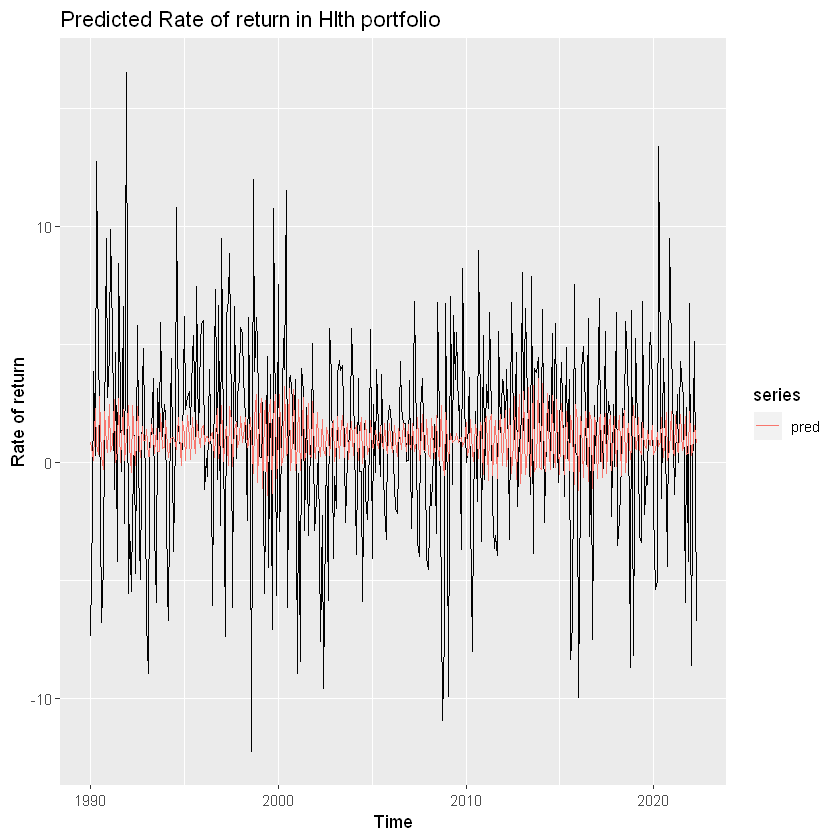

In [8]:
autoplot(true) + autolayer(pred) + labs(y = "Rate of return", title = "Predicted Rate of return in Hlth portfolio")

In [9]:
as.numeric(pred)

[1]  8.464987e-01  3.919102e-01  1.024223e-01  2.289056e+00  7.521487e-01
  [6]  3.309727e-01  2.803313e+00  2.745671e-01 -2.816997e-01  2.164356e+00
 [11]  7.507132e-01  4.425549e-01  2.459102e+00  4.699555e-01  7.508707e-01
 [16]  2.688627e+00  1.221096e-02  4.616430e-01  2.702046e+00  4.979301e-05
 [21]  1.013129e+00  2.262388e+00  9.975560e-02  1.081875e+00  2.419958e+00
 [26]  6.918830e-01 -4.389614e-01  2.422005e+00  6.703404e-01 -1.293979e-01
 [31]  2.359054e+00  7.251752e-01  2.147055e-01  1.545702e+00  9.526188e-01
 [36]  9.200319e-01  1.402736e+00  2.574110e-01  2.551102e-01  1.607534e+00
 [41]  1.089400e+00  3.895765e-01  1.464083e+00  4.636703e-01  4.739049e-01
 [46]  2.081424e+00  5.776281e-01  6.293219e-01  1.779323e+00  7.189663e-01
 [51]  2.100973e-01  1.038887e+00  1.001590e+00  1.060842e+00  8.274899e-01
 [56]  5.425946e-01  1.904664e+00  1.207894e+00 -1.186888e-01  1.758851e+00
 [61]  1.233014e+00  9.752275e-02  1.991766e+00  1.065757e+00  1.412167e-01
 [66]  1.915136e+00  1.158738e+00  3.939177e-01  1.780795e+00  1.199052e+00
 [71]  6.343538e-01  1.443468e+00  1.589332e+00  7.567844e-01  1.111523e+00
 [76]  1.093982e+00  8.227630e-01  1.245009e+00  1.284629e+00  2.082774e-01
 [81]  1.191078e+00  2.275869e+00  1.695974e-01  8.659438e-01  2.423333e+00
 [86]  5.647771e-02  1.307679e+00  1.514040e+00 -1.105528e-01  2.380976e+00
 [91]  1.764208e+00 -1.816860e-01  1.411663e+00  1.704735e+00  6.192403e-01
 [96]  9.694282e-01  1.968968e+00  8.360030e-01  1.123867e+00  1.897221e+00
[101]  6.594709e-01  7.250764e-01  1.920139e+00  1.154957e+00 -4.787365e-01
[106]  1.888647e+00  2.898438e+00 -8.616250e-01  1.865221e+00  2.721962e+00
[111] -1.097516e+00  1.775733e+00  2.635945e+00 -1.377342e+00  1.937049e+00
[116]  2.674897e+00 -1.311288e+00  1.838730e+00  2.886987e+00 -6.927886e-01
[121]  9.396411e-01  2.884639e+00 -1.084124e-01  2.986338e-01  3.236052e+00
[126]  3.099863e-01  4.109239e-01  3.135942e+00 -3.464016e-01  8.377205e-01
[131]  3.114790e+00 -3.195396e-01  7.206429e-01  2.670071e+00 -3.514199e-01
[136]  6.046076e-01  2.763935e+00  1.040810e-01  4.974702e-01  2.494217e+00
[141]  3.364674e-01  2.251769e-01  2.607467e+00  6.574242e-01  1.704145e-01
[146]  2.126458e+00  8.025451e-01  2.529998e-01  1.822947e+00  5.734648e-01
[151]  2.799897e-01  1.479842e+00  1.100921e+00  2.997619e-01  1.351735e+00
[156]  1.794354e+00  5.941867e-02  8.188265e-01  1.944945e+00  1.563661e-01
[161]  1.194916e+00  1.986352e+00  2.068271e-01  1.057239e+00  1.676419e+00
[166]  1.127705e-01  1.204681e+00  1.745949e+00  3.191146e-01  1.341591e+00
[171]  1.554214e+00  1.055934e-01  1.137546e+00  1.916580e+00 -3.265363e-02
[176]  9.290580e-01  1.778128e+00  3.434646e-01  6.621582e-01  1.781387e+00
[181]  6.938833e-01  6.105757e-01  1.345958e+00  1.113492e+00  5.799831e-01
[186]  1.520810e+00  9.126610e-01  5.887361e-01  1.658227e+00  6.293474e-01
[191]  3.901015e-01  1.654655e+00  1.031308e+00  4.361566e-01  1.583298e+00
[196]  9.314720e-01  2.484531e-01  1.462015e+00  9.965050e-01  5.364200e-01
[201]  1.674802e+00  8.814852e-01  4.822798e-01  1.611507e+00  7.972815e-01
[206]  5.757769e-01  1.637653e+00  4.823019e-01  9.049168e-01  1.928531e+00
[211]  7.580384e-02  4.998413e-01  2.034776e+00  5.617289e-01  5.271783e-01
[216]  1.845952e+00  4.013184e-01  1.914911e-01  1.866197e+00  6.519170e-01
[221]  1.694240e-01  1.991008e+00  6.692872e-01  9.239945e-02  2.428803e+00
[226]  2.923635e-01 -5.424173e-01  2.104386e+00  8.875573e-01  3.350805e-02
[231]  1.253442e+00  8.456886e-01  9.097967e-01  9.600216e-01  1.235844e+00
[236]  8.342268e-01  9.991710e-01  1.045754e+00  6.827895e-01  8.900904e-01
[241]  1.688686e+00  3.158958e-01  6.831662e-01  1.833114e+00  4.071938e-01
[246]  3.734267e-02  1.603328e+00  9.683223e-01  1.757258e-01  1.703427e+00
[251]  1.498947e+00 -4.871954e-01  1.597345e+00  1.941557e+00 -7.396407e-01
[256]  1.714906e+00  2.054836e+00 -5.670801e-01  1.257505e+00  1.799698e+00
[261] -6.678281e-01  1.169570e+00  2.036119e+00 -1